In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text # type: ignore

In [4]:
import pandas as pd

data = pd.read_csv("spam.csv")
data.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
data['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [6]:
df_ham = data[data['Category']=='ham']
df_ham.shape

(4825, 2)

In [7]:
df_spam = data[data['Category']=='spam']
df_spam.shape

(747, 2)

In [8]:
df_ham_balanced_sample = df_ham.sample(df_spam.shape[0])
df_ham_balanced_sample.shape

(747, 2)

In [9]:
data_balanced = pd.concat([df_ham_balanced_sample,df_spam])
data_balanced.shape

(1494, 2)

In [10]:
data_balanced['Category'].value_counts()

ham     747
spam    747
Name: Category, dtype: int64

In [11]:
data_balanced['spam'] = data_balanced['Category'].apply(lambda x: 1 if x =='spam' else 0 )
data_balanced.sample(5)

,Category,Message,spam
2309,spam,Moby Pub Quiz.Win a £100 High Street prize if ...,1
1301,ham,Those cocksuckers. If it makes you feel better...,0
4019,ham,GRAN ONLYFOUND OUT AFEW DAYS AGO.CUSOON HONI,0
4549,ham,Hope you are having a good week. Just checking in,0
4115,ham,Where are you ? What do you do ? How can you s...,0


In [12]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(data_balanced['Message'],data_balanced['spam'],stratify=data_balanced['spam'])

In [13]:
y_train.sample(5)

4088    1
840     1
2808    1
3755    1
4934    0
Name: spam, dtype: int64

In [14]:
bert_preprocess = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1')

In [15]:
def sentence_encoder(sentence):
    pre_text = bert_preprocess(sentence)
    return bert_encoder(pre_text)['pooled_output']

sentence_encoder([
    'hello this is run check.',
    'this is second sentence for check'
])

<tf.Tensor: shape=(2, 512), dtype=float32, numpy=
array([[ 0.9933621 ,  0.97333205,  0.12884618, ...,  0.32036042,
        -0.13694291,  0.05297787],
       [ 0.9914664 ,  0.10464615,  0.18319288, ...,  0.34871274,
        -0.28150967, -0.2708791 ]], dtype=float32)>

In [16]:
word = sentence_encoder([
    'apple',
    'banana',
    'cycle',
    'bus',
    'shirt',
    'horse',
    'dog',
    'cat',
    'lion'
])

In [17]:
word

<tf.Tensor: shape=(9, 512), dtype=float32, numpy=
array([[ 0.96825767,  0.4494403 , -0.18196331, ..., -0.15019338,
        -0.62235266,  0.217308  ],
       [ 0.9842703 ,  0.30940858,  0.16240574, ...,  0.11738293,
        -0.4507025 ,  0.02611814],
       [ 0.99402857,  0.43966502, -0.20077421, ...,  0.14415649,
        -0.4184864 , -0.7595779 ],
       ...,
       [ 0.99534273,  0.827905  ,  0.1358913 , ...,  0.45941687,
        -0.5692647 , -0.75793713],
       [ 0.9962467 , -0.35754102, -0.26992577, ...,  0.39836317,
        -0.70694643, -0.4790373 ],
       [ 0.99591   ,  0.11346842, -0.01134887, ..., -0.13424905,
        -0.5127904 ,  0.07381982]], dtype=float32)>

In [18]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity([word[1]],[word[8]])

array([[0.90586483]], dtype=float32)

In [19]:
# bert Layer
input_text = tf.keras.layers.Input(shape=(),dtype=tf.string, name='text')
preprocess_text = bert_preprocess(input_text)
output = bert_encoder(preprocess_text)

# neural network layer
drop = tf.keras.layers.Dropout(0.1, name = 'dropout')(output['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name = 'output')(drop)

model = tf.keras.Model(inputs=[input_text], outputs=[l])

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [21]:
MATRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.Precision(name='precision')
]

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics= MATRICS
)

In [22]:
model.fit(x_train,y_train, epochs=5)

Epoch 1/5
35/35 [==============================] - 73s 2s/step - loss: 0.5300 - accuracy: 0.7705 - recall: 0.7786 - precision: 0.7663
Epoch 2/5
35/35 [==============================] - 55s 2s/step - loss: 0.3436 - accuracy: 0.9143 - recall: 0.9161 - precision: 0.9128
Epoch 3/5
35/35 [==============================] - 60s 2s/step - loss: 0.2661 - accuracy: 0.9348 - recall: 0.9375 - precision: 0.9325
Epoch 4/5
35/35 [==============================] - 61s 2s/step - loss: 0.2282 - accuracy: 0.9420 - recall: 0.9464 - precision: 0.9381
Epoch 5/5
35/35 [==============================] - 58s 2s/step - loss: 0.2003 - accuracy: 0.9518 - recall: 0.9518 - precision: 0.9518


In [23]:
model.evaluate(x_test,y_test)

12/12 [==============================] - 22s 2s/step - loss: 0.1967 - accuracy: 0.9305 - recall: 0.9626 - precision: 0.9045


[0.1966502070426941,
 0.9304812550544739,
 0.9625668525695801,
 0.9045225977897644]

In [24]:
y_predicted = model.predict(x_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 17s 1s/step


In [25]:
import numpy as np

y_predicted = np.where(y_predicted >0.5, 1,0)
y_predicted

array([1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,

In [26]:
from sklearn.metrics import confusion_matrix,classification_report

cm = confusion_matrix(y_test,y_predicted)
cm

array([[168,  19],
       [  7, 180]], dtype=int64)

Text(50.722222222222214, 0.5, 'True Value')

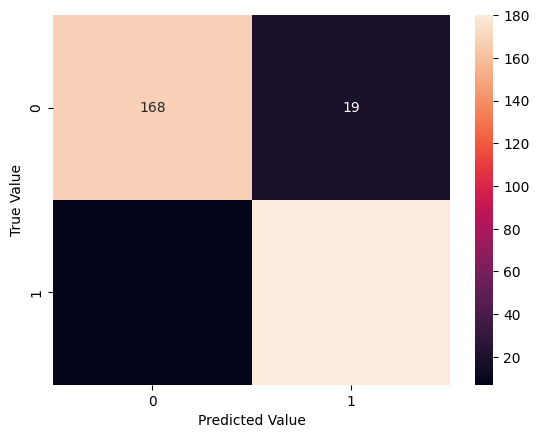

In [27]:
from matplotlib import pyplot as plt 
import seaborn as sns

sns.heatmap(cm, annot = True,fmt='d')
plt.xlabel('Predicted Value')
plt.ylabel('True Value')


In [28]:
print(classification_report(y_test,y_predicted))

              precision    recall  f1-score   support

           0       0.96      0.90      0.93       187
           1       0.90      0.96      0.93       187

    accuracy                           0.93       374
   macro avg       0.93      0.93      0.93       374
weighted avg       0.93      0.93      0.93       374



In [29]:
# Quantization Technique to reduce model size 

In [30]:
model.save("./save_models/")

INFO:tensorflow:Assets written to: ./save_models/assets


INFO:tensorflow:Assets written to: ./save_models/assets


In [31]:
# without quantization
converter = tf.lite.TFLiteConverter.from_saved_model("./save_models")
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS, 
    tf.lite.OpsSet.SELECT_TF_OPS
]

# Disable experimental tensor list lowering
converter._experimental_lower_tensor_list_ops = False

tflite_model = converter.convert()

In [32]:
# with quantization
converter = tf.lite.TFLiteConverter.from_saved_model('./save_models')

converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS, 
    tf.lite.OpsSet.SELECT_TF_OPS
]

# Disable experimental tensor list lowering
converter._experimental_lower_tensor_list_ops = False

converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_optimize_model = converter.convert()

In [33]:
len(tflite_model)

115170308

In [34]:
len(tflite_optimize_model)

29751984